In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:

import os
import sys
import json

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
import numpy as np

%matplotlib inline

In [44]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [45]:
# where WellClass and Ga[ codes are located
sys.path.append('../')

In [46]:
# WellClass
# from well_class_v2 import csv_parser, Well
from src.WellClass.libs.utils import (
    csv_parser,
    yaml_parser
)

from src.WellClass.libs.well_class import Well
from src.WellClass.libs.well_pressure import Pressure



# plots
from src.WellClass.libs.plotting import (
    plot_pressure,
    plot_pt,
    plot_sketch,
    plot_onepager
)

## Some user options

In [47]:
# use yaml or csv input file
use_yaml = True

In [48]:
# pick an example from given three options

case_type = 'wildcat'

case_type = 'smeaheia_v1'

# case_type = 'smeaheia_v2'

In [49]:
# where pvt located
pvt_path = '../src/WellClass/libs/pvt/pvt_constants/pure_co2'

# Examples

The following are the test examples.

In [50]:
# examples
smeaheia_v1 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/eim/SMEAHEIA', 
               'sim_path': r'../test_data/examples/smeaheia_v1',
               'simcase': r'GEN_NOLGR_PH2'}
smeaheia_v2 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model', 
               'sim_path': r'../test_data/examples/smeaheia_v2', 
               'simcase': r'TEMP-0'}
wildcat = {
         'well_input': r'GaP_input_Wildcat_v3.csv', 
         'well_input_yaml': r'wildcat.yaml', 
        #  'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model', 
         'sim_path': r'../test_data/examples/wildcat', 
         'simcase': r'TEMP-0'}

In [51]:
examples = {
    'smeaheia_v1': smeaheia_v1,
    'smeaheia_v2': smeaheia_v2,
    'wildcat': wildcat
}

# Load well CSV or yaml configuration file

Process CSV with well class.
Predefine a dictionary that includes the input CSV well file, the simulation path, and the PFT sim case name

In [52]:
# the selected example for testing
case = examples[case_type]


In [53]:

# root_path = '/scratch/SCS/gpb/SCREEN/GaP_code'

sim_path = case['sim_path']


In [54]:
if use_yaml:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input_yaml'])
    
    # # pydantic model
    well_model = yaml_parser(well_name)
    well_csv = json.loads(well_model.spec.model_dump_json())
else:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input'])

    # load the well information
    well_csv = csv_parser(well_name)

In [55]:
#Process well by running well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
           )

## Generation of Pressure tables
### 1. Minimum input: 

The pressure class can be initialized with a minimum of the following parameters:
- Depth to seabed in mTVDMSL
- Wellbore TD in mRKB
- Wellbore RKB in mTVDMSL
- Seafloor temperature in degC. Defaulted to 4 degC
- Geothermal gradient in degC/km. Defaulted to 40 degC/km
- Fluid type: This depends on the PVT tables available on pvtpath 
  - pure CO2, Components: 100% CO2
  - pure C1, Components: 100% CH4
  - mixture 1, Components: 96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4
  - mixture 2, Components: 95% CO2, 5% CH4
- Path to the PVT tables


If depth of fluid contact is provided, by default Pressure class will calculate a pressure scenario with a hydrosatic gradient from the fluid contact to the surface

In [56]:
my_pressure = Pressure(sf_depth_msl=well_csv['well_header']['sf_depth_msl'],
                       well_td_rkb=well_csv['well_header']['well_td_rkb'],
                       well_rkb=well_csv['well_header']['well_rkb'],
                       sf_temp=well_csv['well_header']['sf_temp'],
                       geo_tgrad=well_csv['well_header']['geo_tgrad'],
                       fluid_type='pure_co2',
                       z_fluid_contact=well_csv['co2_datum'],
                       pvt_path='../src/WellClass/libs/pvt/pvt_constants')

Computing pressure profile for scenario: hydrostatic


In [57]:
my_pressure.scenario_manager.get_scenarios_summary()

,name,from_resrvr,z_MSAD,p_MSAD,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,hydrostatic,True,552.053763,73.114595,1282.5,130.012627,1282.5,130.012627,0,pure_co2,100% CO2,None


If other fluid compostions want to be added and compared, the user can pick between pure CO2, mixture1, mixture2 or pure methane, or provide its own specific gravity

In [58]:
my_pressure = Pressure(sf_depth_msl=well_csv['well_header']['sf_depth_msl'],
                       well_td_rkb=well_csv['well_header']['well_td_rkb'],
                       well_rkb=well_csv['well_header']['well_rkb'],
                       sf_temp=well_csv['well_header']['sf_temp'],
                       geo_tgrad=well_csv['well_header']['geo_tgrad'],
                       fluid_type='pure_co2',
                       pvt_path='../src/WellClass/libs/pvt/pvt_constants')

fluid_contact = well_csv['co2_datum']
my_pressure.add_scenario(scenario_name='mixture1', fluid_type='mixture1', from_resrvr=True, z_fluid_contact=fluid_contact)
my_pressure.add_scenario(scenario_name='methane', fluid_type='methane', from_resrvr=True, z_fluid_contact=fluid_contact)
my_pressure.add_scenario(scenario_name='sg_input', fluid_type=None, from_resrvr=True, specific_gravity=300/1e3, z_fluid_contact=fluid_contact)

my_pressure.scenario_manager.get_scenarios_summary()

Computing pressure profile for scenario: mixture1
Computing pressure profile for scenario: methane
Computing pressure profile for scenario: sg_input


,name,from_resrvr,z_MSAD,p_MSAD,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,mixture1,True,569.885611,76.137093,1282.5,130.012627,1282.5,130.012627,0,mixture1,"96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4",NaN
1,methane,True,863.913499,125.974820,1282.5,130.012627,1282.5,130.012627,0,methane,100% CH4,NaN
2,sg_input,True,804.825944,115.959480,1282.5,130.012627,1282.5,130.012627,0,None,None,0.3


If simple input scenarios are provided in the input_scenarios argument, these will be computed

In [59]:
my_pressure = Pressure(sf_depth_msl=well_csv['well_header']['sf_depth_msl'],
                       well_td_rkb=well_csv['well_header']['well_td_rkb'],
                       well_rkb=well_csv['well_header']['well_rkb'],
                       sf_temp=well_csv['well_header']['sf_temp'],
                       geo_tgrad=well_csv['well_header']['geo_tgrad'],
                       fluid_type='pure_co2',
                       input_scenarios=well_csv['reservoir_pressure'],
                       z_fluid_contact=well_csv['co2_datum'],
                       pvt_path='../src/WellClass/libs/pvt/pvt_constants')

my_pressure.scenario_manager.get_scenarios_summary()

Computing pressure profile for scenario: RP1
Computing pressure profile for scenario: RP2
Computing pressure profile for scenario: RP3


,name,from_resrvr,z_MSAD,p_MSAD,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,RP1,True,552.053763,73.114595,1282.5,130.012627,1282.5,130.012627,0.0,pure_co2,100% CO2,None
1,RP2,True,NaN,NaN,1282.5,221.012627,1282.5,221.012627,91.0,pure_co2,100% CO2,None
2,RP3,True,764.080956,109.053204,1282.5,150.012627,1282.5,150.012627,20.0,pure_co2,100% CO2,None


### 2. Create a pressure scenario

Create a pressure scenario providing only the **MSAD** (the `from_resrv` flag has to be False )

In [60]:
my_pressure = Pressure(sf_depth_msl=well_csv['well_header']['sf_depth_msl'],
                       well_td_rkb=well_csv['well_header']['well_td_rkb'],
                       well_rkb=well_csv['well_header']['well_rkb'],
                       sf_temp=well_csv['well_header']['sf_temp'],
                       geo_tgrad=well_csv['well_header']['geo_tgrad'],
                       fluid_type='pure_co2',
                       default_hs_scenario=False,
                    #    z_fluid_contact=1300,
                       pvt_path='../src/WellClass/libs/pvt/pvt_constants')

my_pressure.add_scenario(scenario_name='plug', from_resrvr=False, z_MSAD = 500, z_fluid_contact = 1300)



Computing pressure profile for scenario: plug
Lines do not intersect


In [61]:
my_pressure.scenario_manager.get_scenarios_summary()

,name,from_resrvr,z_MSAD,p_MSAD,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,plug,False,500,64.291482,1300,126.145786,1300,126.145786,-5.618736,pure_co2,100% CO2,None


Create a pressure scenario providing only the **delta Pressure +/-** and depth **fluid_contact**. The code assumes the reservoir depth is the same as the `co2_datum` (the `from_resrv` flag has to be True )

In [62]:
my_pressure = Pressure(sf_depth_msl=well_csv['well_header']['sf_depth_msl'],
                       well_td_rkb=well_csv['well_header']['well_td_rkb'],
                       well_rkb=well_csv['well_header']['well_rkb'],
                       sf_temp=well_csv['well_header']['sf_temp'],
                       geo_tgrad=well_csv['well_header']['geo_tgrad'],
                       fluid_type='pure_co2',
                       default_hs_scenario=False,
                    #    z_fluid_contact=1300,
                       pvt_path='../src/WellClass/libs/pvt/pvt_constants',
                     #   shmin_gradient=0.1855
                       )

my_pressure.add_scenario(scenario_name='test1', from_resrvr=True, p_delta = 25, z_fluid_contact = my_well.co2_datum)

my_pressure.scenario_manager.get_scenarios_summary()

Computing pressure profile for scenario: test1


,name,from_resrvr,z_MSAD,p_MSAD,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,test1,True,818.220032,118.229778,1282.5,155.012627,1282.5,155.012627,25,pure_co2,100% CO2,None


In [63]:
my_pressure = Pressure(sf_depth_msl=well_csv['well_header']['sf_depth_msl'],
                       well_td_rkb=well_csv['well_header']['well_td_rkb'],
                       well_rkb=well_csv['well_header']['well_rkb'],
                       sf_temp=well_csv['well_header']['sf_temp'],
                       geo_tgrad=well_csv['well_header']['geo_tgrad'],
                       fluid_type='pure_co2',
                       default_hs_scenario=False,
                    #    z_fluid_contact=1300,
                       pvt_path='../src/WellClass/libs/pvt/pvt_constants',
                       shmin_gradient=0.1855
                       )

my_pressure.add_scenario(scenario_name='test1', from_resrvr=True, p_delta = 25, z_fluid_contact = my_well.co2_datum)

my_pressure.scenario_manager.get_scenarios_summary()

Computing pressure profile for scenario: test1


,name,from_resrvr,z_MSAD,p_MSAD,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,test1,True,738.505548,111.542261,1282.5,155.012627,1282.5,155.012627,25,pure_co2,100% CO2,None


Create a pressure scenario providing only the **delta Pressure +/-** at reservoir and the reservoir depth (the `from_resrv` flag has to be True )

In [64]:
my_pressure.add_scenario(scenario_name='test2', from_resrvr=True, p_delta = 10, z_resrv=1180, z_fluid_contact = my_well.co2_datum)

my_pressure.scenario_manager.get_scenarios_summary()

Computing pressure profile for scenario: test2


,name,from_resrvr,z_MSAD,p_MSAD,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,test1,True,738.505548,111.542261,1282.5,155.012627,1282.5,155.012627,25,pure_co2,100% CO2,None
1,test2,True,602.108974,86.240697,1180.0,132.477676,1282.5,140.012627,10,pure_co2,100% CO2,None


Create a pressure scenario providing a pressure measurement (value) and its correspoinding depth (the `from_resrv` flag has to be True )

In [65]:
my_pressure.add_scenario(scenario_name='test3', from_resrvr=True, z_resrv=1100, p_resrv=200)

my_pressure.scenario_manager.get_scenarios_summary()


Computing pressure profile for scenario: test3
self.z_fluid_contact=None


,name,from_resrvr,z_MSAD,p_MSAD,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,test1,True,738.505548,111.542261,1282.5,155.012627,1282.5,155.012627,25.000000,pure_co2,100% CO2,None
1,test2,True,602.108974,86.240697,1180.0,132.477676,1282.5,140.012627,10.000000,pure_co2,100% CO2,None
2,test3,True,NaN,NaN,1100.0,200.000000,1100.0,200.000000,88.280409,pure_co2,100% CO2,None


In [66]:
my_pressure.scenario_manager.scenarios['test3'].init_curves

,depth,temperature,hydrostatic_pressure,min_horizontal_stress,fluid_pressure,brine_pressure
0,0.0,4.00,1.013250,1.013250,99.718773,88.848315
1,1.0,4.00,1.113848,1.113848,99.812273,88.949342
2,2.0,4.00,1.214446,1.214446,99.905785,89.050369
3,3.0,4.00,1.315045,1.315045,99.999309,89.151397
4,4.0,4.00,1.415644,1.415644,100.092844,89.252425
...,...,...,...,...,...,...
3657,3657.0,137.80,362.425614,652.922982,NaN,451.620944
3658,3658.0,137.84,362.520693,653.108482,NaN,451.716200
3659,3659.0,137.88,362.615771,653.293982,NaN,451.811453
3660,3660.0,137.92,362.710845,653.479482,NaN,451.906702


# Visualization

,name,from_resrvr,z_MSAD,p_MSAD,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta,fluid_type,fluid_composition,specific_gravity
0,test1,True,738.505548,111.542261,1282.5,155.012627,1282.5,155.012627,25.000000,pure_co2,100% CO2,None
1,test2,True,602.108974,86.240697,1180.0,132.477676,1282.5,140.012627,10.000000,pure_co2,100% CO2,None
2,test3,True,NaN,NaN,1100.0,200.000000,1100.0,200.000000,88.280409,pure_co2,100% CO2,None


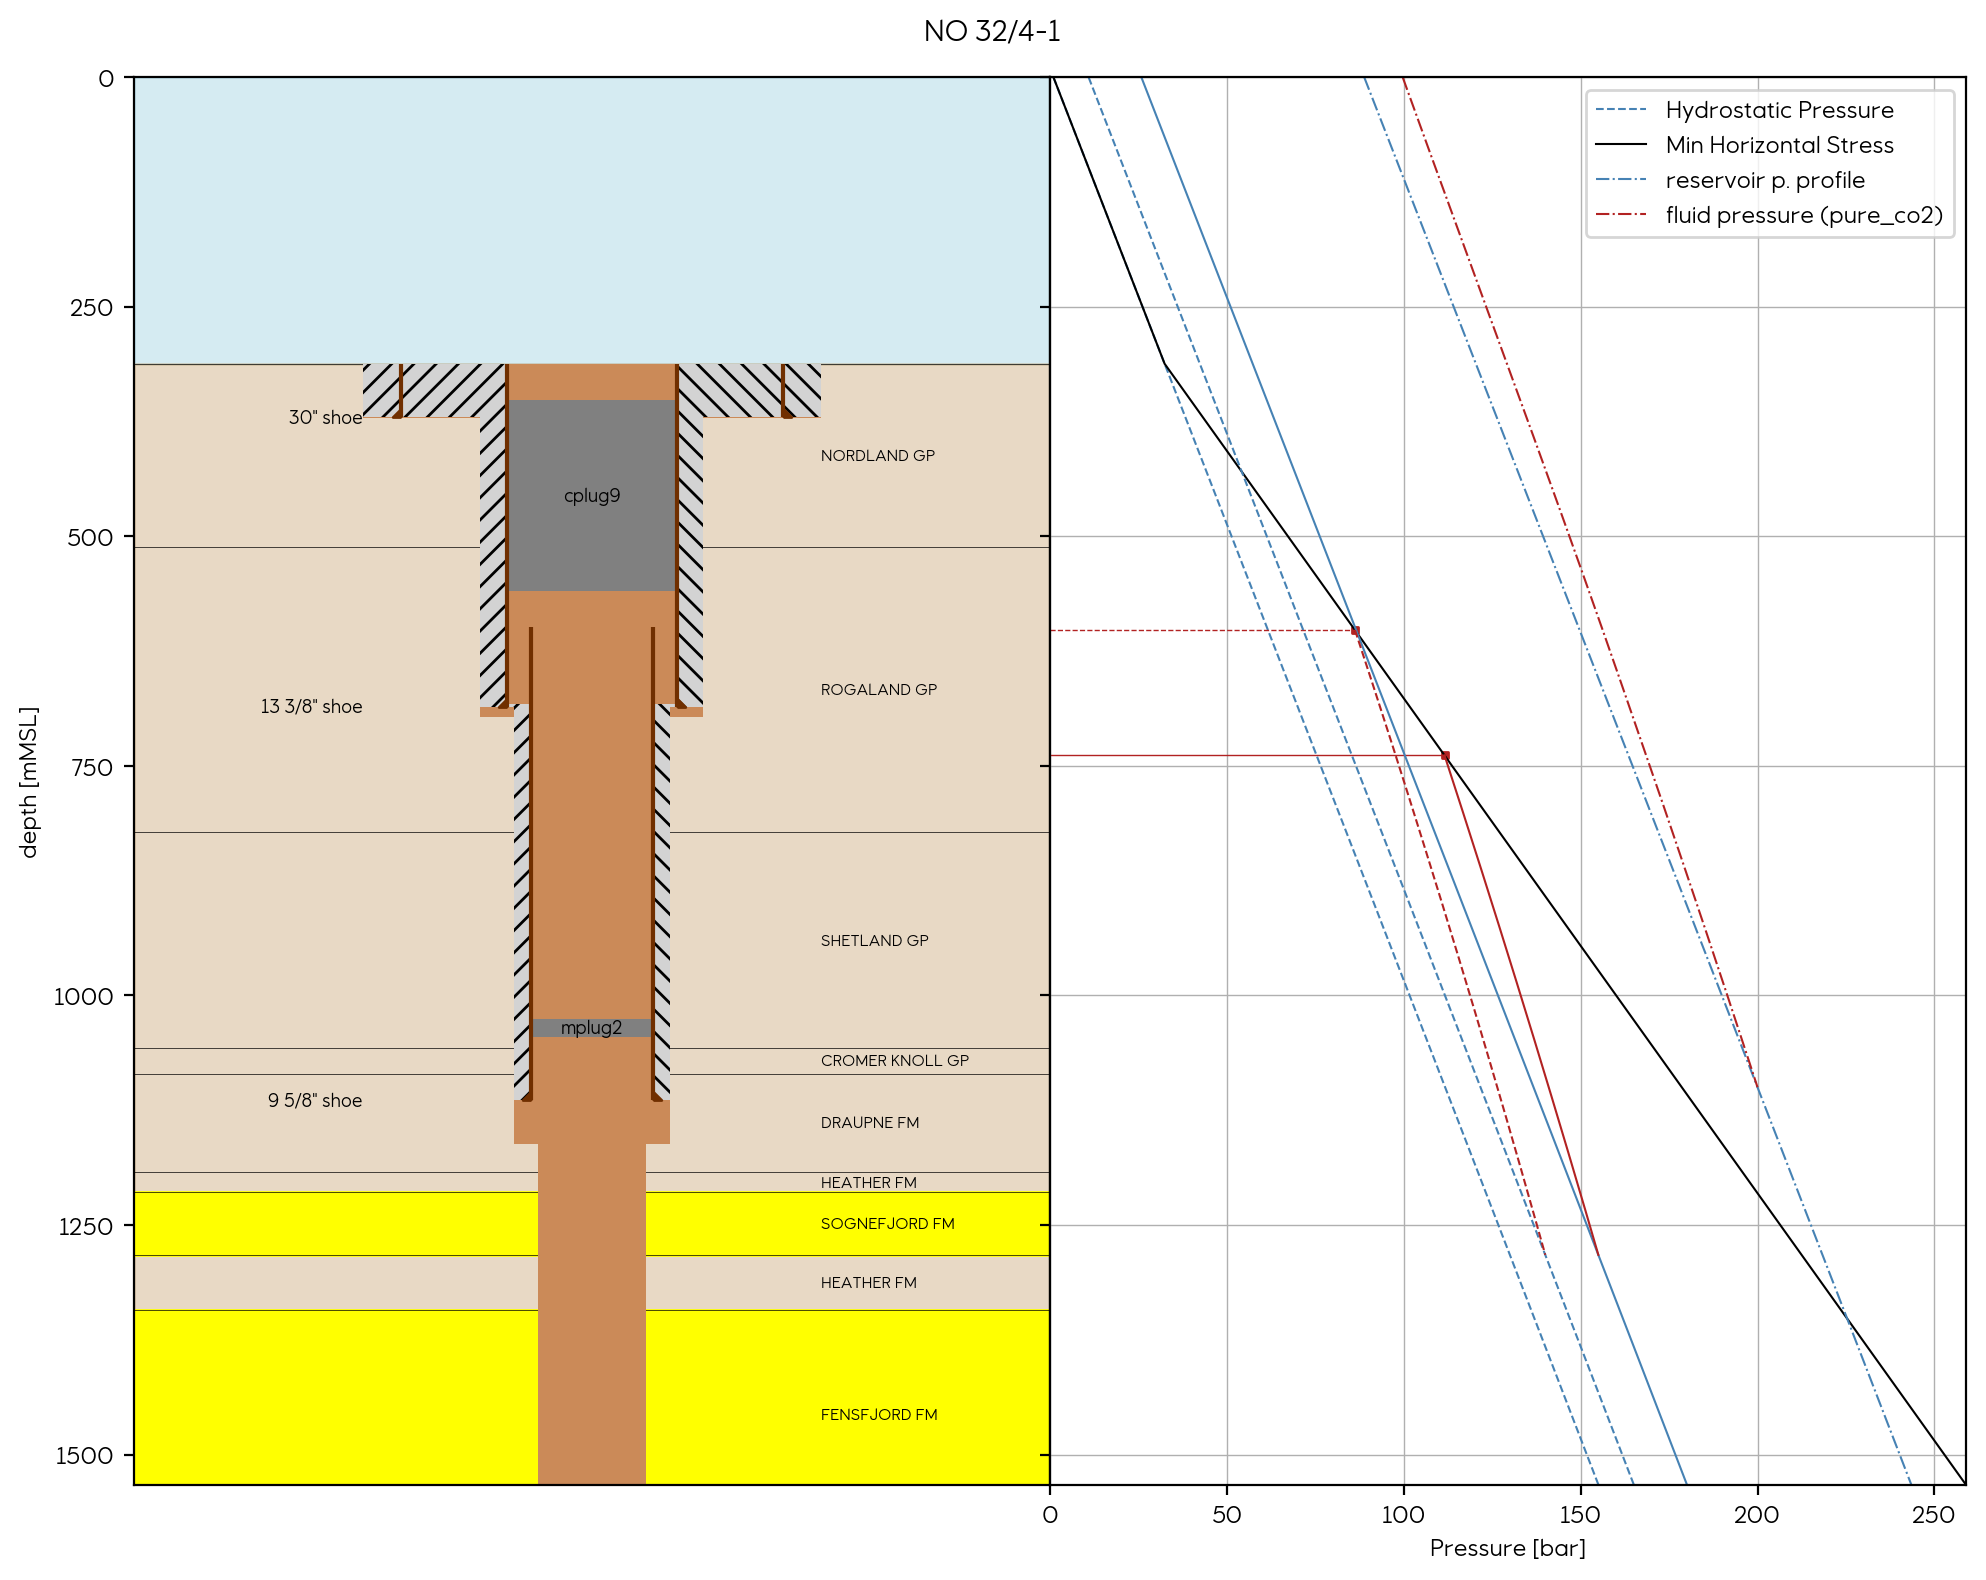

In [67]:
fig, ax1, ax2 = plot_onepager( my_well, my_pressure, plot_MSAD=True, plot_HSP=True)


# CO2 Leakage

In [68]:
# pick one barrier
main_barrier = well_csv['main_barrier']
main_barrier

'cplug9'

In [69]:
my_well.barrier_perm

{'quality': ['good', 'mid', 'poor'], 'kv': [0.01, 10, 1000.0]}

In [70]:
my_pressure.compute_barrier_leakage(well=my_well, barrier_name=main_barrier)

,p_brine_above_barrier,p_fluid_below_barrier,rho_brine_below_barrier,rho_fluid_below_barrier,0.01,10,1000.0
test1,36.404761,96.130279,1027.456485,893.389973,0.0,0.02349,2.36091
test2,36.404761,82.582736,1027.456485,879.392318,0.0,0.01848,1.85960
test3,36.404761,152.344035,1027.456485,936.756133,0.0,0.04441,4.45239
